In [2]:
import random
import time
from itertools import product, islice
from tqdm.auto import tqdm

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision

from precisionml.optimizers import ConjugateGradients

In [3]:
########### Set Device ############
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
dtype = torch.float64
torch.set_default_dtype(dtype)
print("Using device: {}".format(device))

Using device: cuda:0


In [1]:
# although this method allows for nice-looking code, it is too slow
# for large batch sizes to iterate within python through inputs

# def loader_for_function(f, ranges, device=device, dtype=dtype):
#     def get_batch(N=1000):
#         xs = []
#         ys = []
#         for _ in range(N):   
#             x = tuple(r1 + (r2 - r1) * np.random.rand() for r1, r2 in ranges)
#             y = f(*x)
#             xs.append(x)
#             ys.append(y)
#         xs = torch.tensor(xs).to(dtype).to(device)
#         ys = torch.tensor(ys).unsqueeze(1).to(dtype).to(device)
#         return xs, ys
    
#     return get_batch

### Let's see what kind of accuracy we can get on the identity f(x) = x

In [18]:
batch_size = 1000
steps = 1000

def batch_loader(N=batch_size, device=device, dtype=dtype):
    x = torch.rand((N, 1), device=device, dtype=dtype)
    return x, x

width = 200
mlp = nn.Sequential(
    nn.Linear(1, width),
    nn.ReLU(),
    nn.Linear(width, width),
    nn.ReLU(),
    nn.Linear(width, 1)
).to(device)

loss_fn = lambda x, y: torch.sqrt(torch.mean(torch.pow(x - y, 2)))
# loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(mlp.parameters())

for i in tqdm(range(steps)):
    optimizer.zero_grad()
    x, y = batch_loader(batch_size)
    loss = loss_fn(mlp(x), y)
    if i % (steps // 20) == 0:
        print(loss.item())
    loss.backward()
    optimizer.step()

  0%|          | 0/1000 [00:00<?, ?it/s]

0.6215136914354132
0.016632206740054164
0.008221486522347624
0.009169951476469337
0.00685257831441799
0.008023308464678752
0.00679671055176372
0.008869029340940868
0.0066730895331963015
0.005886731526323771
0.009131280998136293
0.007582855183800114
0.005454468589275011
0.007773877961192291
0.007977107162661598
0.006975031095137714
0.0069035481941631584
0.007450874830133905
0.007500273508325325
0.004167638383897212


In [25]:
batch_size = 1000
steps = 100000

def batch_loader(N=batch_size, device=device, dtype=dtype):
    x = torch.rand((N, 1), device=device, dtype=dtype)
    return x, x

width = 200
mlp = nn.Sequential(
    nn.Linear(1, width),
    nn.Tanh(),
    nn.Linear(width, width),
    nn.Tanh(),
    nn.Linear(width, 1)
).to(device)

loss_fn = lambda x, y: torch.sqrt(torch.mean(torch.pow(x - y, 2)))
# loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(mlp.parameters())
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)

for i in tqdm(range(steps)):
    optimizer.zero_grad()
    x, y = batch_loader(batch_size)
    loss = loss_fn(mlp(x), y)
    if i % (steps // 30) == 0:
        print(loss.item())
        scheduler.step()
    loss.backward()
    optimizer.step()

  0%|          | 0/100000 [00:00<?, ?it/s]

0.3402119097494031
0.0038755328257858643
0.0027832232089777804
0.001957876152971073
0.0013187170135408354
0.0012577637974300999
0.0008789397889795287
0.0006812021540133076
0.0005070912454314665
0.00047577732695577103
0.0003311467404238318
0.00031014630712091065
0.0002551778054488398
0.00020023424261374591
0.00014436231955539314
0.00012453629987910342
9.370422506429543e-05
9.044399149075197e-05
6.128427187672664e-05
5.7458615048336796e-05
4.921363691350252e-05
4.785105796230194e-05
2.573895153549037e-05
2.3995503304544258e-05
2.0669365310416863e-05
1.781653741071639e-05
1.6320878909139857e-05
1.5448738049522897e-05
1.5149893748034199e-05
1.5194231085639418e-05
1.4382337285767065e-05


In [3]:
def get_batch(size=500, magnitude=5.0, device=device, dtype=dtype):
    x = 2 * magnitude * torch.rand((size, 2), dtype=dtype) - magnitude
    y = torch.unsqueeze(torch.prod(x, dim=1), dim=1)
    return x.to(device), y.to(device)

In [17]:
mlp = nn.Sequential(
    nn.Linear(2, 4, bias=False),
    nn.Softplus(),
    nn.Linear(4, 1, bias=False)
).to(device)

# loss_fn = lambda x, y: torch.sqrt(torch.mean(torch.pow(x - y, 2)))
loss_fn = nn.MSELoss()
# loss_fn = lambda x, y: torch.mean(0.5 * torch.log(1.0 + torch.pow(x - y, 2)))
lambduh = 0.00001
sigma_2nd_der = 1 / 4
mu = np.power(lambduh, -2) / (4 * sigma_2nd_der)

mlp[0].weight.data[0, 0] = lambduh
mlp[0].weight.data[0, 1] = lambduh
mlp[0].weight.data[1, 0] = -lambduh
mlp[0].weight.data[1, 1] = -lambduh
mlp[0].weight.data[2, 0] = lambduh
mlp[0].weight.data[2, 1] = -lambduh
mlp[0].weight.data[3, 0] = -lambduh
mlp[0].weight.data[3, 1] = lambduh

mlp[2].weight.data[0, 0] = mu
mlp[2].weight.data[0, 1] = mu
mlp[2].weight.data[0, 2] = -mu
mlp[2].weight.data[0, 3] = -mu

# perturb
mlp[0].weight.data += 0.000000001 * torch.randn(mlp[0].weight.shape).to(device)
# mlp[2].weight.data += 0.000000001 * torch.randn(mlp[2].weight.shape).to(device)

optimizer = ConjugateGradients(mlp.parameters())
# optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-8)

def get_loss_on(x, y):
    def loss():
        return loss_fn(mlp(x), y)
    return loss

for t in range(10):
    x, y = get_batch(size=5000000, device=device)
    for param in mlp.parameters():
        param.grad = None
    loss = loss_fn(mlp(x), y)
    print(loss.item())
    loss.backward()
    optimizer.step(get_loss_on(x, y))
#     optimizer.reset()

1837.8159642335986
9.99063111981725e-06
1.5689027854239416e-06
1.5662918368236948e-06
1.566570273820423e-06
1.5687781653125516e-06
1.5691333798480043e-06
1.5699990578855427e-06
1.5665213241379912e-06
1.5658878766714352e-06


In [41]:
mlp = nn.Sequential(
    nn.Linear(2, 4, bias=False),
    nn.Softplus(),
    nn.Linear(4, 1, bias=False)
).to(device)

# loss_fn = lambda x, y: torch.sqrt(torch.mean(torch.pow(x - y, 2)))
loss_fn = nn.MSELoss()
# loss_fn = lambda x, y: torch.mean(0.5 * torch.log(1.0 + torch.pow(x - y, 2)))
lambduh = 0.00001
sigma_2nd_der = 1 / 4
mu = np.power(lambduh, -2) / (4 * sigma_2nd_der)

mlp[0].weight.data[0, 0] = lambduh
mlp[0].weight.data[0, 1] = lambduh
mlp[0].weight.data[1, 0] = -lambduh
mlp[0].weight.data[1, 1] = -lambduh
mlp[0].weight.data[2, 0] = lambduh
mlp[0].weight.data[2, 1] = -lambduh
mlp[0].weight.data[3, 0] = -lambduh
mlp[0].weight.data[3, 1] = lambduh

mlp[2].weight.data[0, 0] = mu
mlp[2].weight.data[0, 1] = mu
mlp[2].weight.data[0, 2] = -mu
mlp[2].weight.data[0, 3] = -mu

# perturb
mlp[0].weight.data += 0.000000001 * torch.randn(mlp[0].weight.shape).to(device)
# mlp[2].weight.data += 0.000000001 * torch.randn(mlp[2].weight.shape).to(device)

# optimizer = ConjugateGradients(mlp.parameters())
# optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-8)
optimizer = torch.optim.LBFGS(mlp.parameters(), line_search_fn='strong_wolfe')

def get_loss_on(x, y):
    def loss():
        return loss_fn(mlp(x), y)
    return loss

for t in range(10):
    x, y = get_batch(size=5000000, device=device)
    for param in mlp.parameters():
        param.grad = None
    loss = loss_fn(mlp(x), y)
    print(loss.item())
    loss.backward()
    optimizer.step(get_loss_on(x, y))
#     optimizer.reset()

4541.355698439289
0.00024350339322852722
1.6888223747325525e-06
1.6167086323486558e-06
1.6132424365053562e-06
1.6155498028812036e-06
1.6160667856715122e-06
1.6183325045384076e-06
1.6157386511744902e-06
1.6172515571821007e-06


In [49]:
batch_size = 1000
steps = 1000

def batch_loader(N=batch_size, device=device, dtype=dtype):
    x = torch.rand((N, 1), device=device, dtype=dtype)
    return x, x

width = 1000
mlp = nn.Sequential(
    nn.Linear(1, width),
    nn.Tanh(),
    nn.Linear(width, width),
    nn.Tanh(),
    nn.Linear(width, 1)
).to(device)

# loss_fn = lambda x, y: torch.sqrt(torch.mean(torch.pow(x - y, 2)))
loss_fn = nn.MSELoss()
# optimizer = torch.optim.Adam(mlp.parameters())
optimizer = torch.optim.LBFGS(mlp.parameters())
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)

def get_loss_on(x, y):
    def loss():
        return loss_fn(mlp(x), y)
    return loss

for i in tqdm(range(steps)):
    optimizer.zero_grad()
    x, y = batch_loader(batch_size)
    loss = loss_fn(mlp(x), y)
    if i % (steps // 30) == 0:
        print(loss.item())
        scheduler.step()
    loss.backward()
    optimizer.step(get_loss_on(x, y))

  0%|          | 0/1000 [00:00<?, ?it/s]

0.34346171468939457
8.294543685305164e-05
1.8324633178244746e-05
1.5079140671388769e-05
1.2482727931885166e-06
8.041948588398111e-07
6.935735764317089e-07
7.178304960709016e-07
7.048249439302676e-07
6.61595078429851e-07
6.169023720261465e-07
6.674474383852554e-07
7.463504492384863e-07
7.023326050895587e-07
6.826318520554893e-07
6.589996260773685e-07
6.653843877715709e-07
6.633753570108896e-07
6.977112082560682e-07
6.812314341249032e-07
6.767246152840558e-07
6.863075445666013e-07
6.451450297818992e-07
6.570866426872617e-07
6.620975636743754e-07
6.720849508881183e-07
6.704449149065174e-07
6.691755201551307e-07
6.208549037832126e-07
6.539695993544596e-07
6.465091557074017e-07


In [48]:
torch.sqrt(torch.mean(torch.pow(mlp(x) - y, 2))).item()

0.0006520323989782889

In [48]:
batch_size = 10000
steps = 1000

def batch_loader(N=batch_size, device=device, dtype=dtype):
    x = torch.rand((N, 1), device=device, dtype=dtype)
    return x, x

width = 200
mlp = nn.Sequential(
    nn.Linear(1, width),
    nn.Tanh(),
    nn.Linear(width, width),
    nn.Tanh(),
    nn.Linear(width, 1)
).to(device)

loss_fn = lambda x, y: torch.sqrt(torch.mean(torch.pow(x - y, 2)))
# loss_fn = nn.MSELoss()
optimizer = GradientSearch(mlp.parameters())

def get_loss_on(x, y):
    def loss():
        return loss_fn(mlp(x), y)
    return loss

for i in tqdm(range(steps)):
    optimizer.zero_grad()
    x, y = batch_loader(batch_size)
    loss = loss_fn(mlp(x), y)
    if i % (steps // 50) == 0:
        print(loss.item())
    loss.backward()
    optimizer.step(get_loss_on(x, y))

  0%|          | 0/1000 [00:00<?, ?it/s]

0.5802282766689215
0.012556786702098652
0.008603945423605049
0.007910701846506111
0.004467205770984088
0.004192988165117967
0.004109117304133539
0.003967926173327114
0.0038609906074635434
0.003862112513919313
0.003750203328066008
0.0036848227795535245
0.0036846037636736337
0.0036249718026108097
0.003604131056705896
0.003525027808091917
0.0035075534273216343
0.003455586490789744
0.003345644791616197
0.0033491081856328476
0.0033172437176913648
0.0033712126528068036
0.0033005015079467653
0.003332339627846163
0.0033045612881356166
0.0033529064160614133
0.0033120300454531383
0.0032889802652026202
0.0032506353441967947
0.0032517986600214305
0.003249013608719287
0.003267867745909247
0.003293020826915775
0.003285123374865273
0.003254319808781407
0.0032370786269321646
0.0032268431692896384
0.0032374681693674015
0.003243107964870443
0.0032381076791539124
0.003244658186640452
0.0032379139418580384
0.003197489636487112
0.003261862933622493
0.0032032690025550294
0.0031807588289789043
0.003184930118

In [49]:
batch_size = 10000
steps = 1000

def batch_loader(N=batch_size, device=device, dtype=dtype):
    x = torch.rand((N, 1), device=device, dtype=dtype)
    return x, x

width = 200
mlp = nn.Sequential(
    nn.Linear(1, width),
    nn.Tanh(),
    nn.Linear(width, width),
    nn.Tanh(),
    nn.Linear(width, 1)
).to(device)

loss_fn = lambda x, y: torch.sqrt(torch.mean(torch.pow(x - y, 2)))
# loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(mlp.parameters())

for i in tqdm(range(steps)):
    optimizer.zero_grad()
    x, y = batch_loader(batch_size)
    loss = loss_fn(mlp(x), y)
    if i % (steps // 50) == 0:
        print(loss.item())
    loss.backward()
    optimizer.step()
    
def get_loss_on(x, y):
    def loss():
        return loss_fn(mlp(x), y)
    return loss

optimizer = GradientSearch(mlp.parameters())
    
for i in tqdm(range(steps)):
    optimizer.zero_grad()
    x, y = batch_loader(batch_size)
    loss = loss_fn(mlp(x), y)
    if i % (steps // 50) == 0:
        print(loss.item())
    loss.backward()
    optimizer.step(get_loss_on(x, y))

  0%|          | 0/1000 [00:00<?, ?it/s]

0.596597865964254
0.16527397928980034
0.1515326103583527
0.12388647054772055
0.1058342509837756
0.09510941664016952
0.08841844748891863
0.08313431210326361
0.07802141841159543
0.0743273198164449
0.07038349717089902
0.06771809303288238
0.06441873136843128
0.06196300562135732
0.05877941664365911
0.05768720616689987
0.055286087914244296
0.05489223323917382
0.05063932382366036
0.04886912335846623
0.047339204914950056
0.04776486004578241
0.044343422531500545
0.04549187640841335
0.04285294864178607
0.0433429924137831
0.03953854394231662
0.04159739203324057
0.03798115266895868
0.03890225028658445
0.036683728382152773
0.038020987150284104
0.03496047321120063
0.03682813268302742
0.034043346057094845
0.035623425493341354
0.03193717006690031
0.034156529441688926
0.031292762020494115
0.03265197591810669
0.029619189848940724
0.03127272741571547
0.029073286323050413
0.03068533537330858
0.02986133106196708
0.030609974531465797
0.027873955254147098
0.027963292022968097
0.027878259359813338
0.028796765

  0%|          | 0/1000 [00:00<?, ?it/s]

0.025505997099907977
0.0008302708066344926
0.0008340144396651931
0.0008320717060894202
0.0008277521627004315
0.0008219682901235305
0.0008204126082111068
0.0008238528688335803
0.0008175449557135757
0.0008205425263474627
0.0008119143039377235
0.0008000305231799252
0.0008094692983450749
0.0008130712978199151
0.0008136199736661495


KeyboardInterrupt: 

## Okay let's just try a bunch of random shit to try to learn the identity function

In [69]:
batch_size = 5000

def batch_loader(N=batch_size, device=device, dtype=dtype):
    x = torch.rand((N, 1), device=device, dtype=dtype)
    return x, x

width = 1000
mlp = nn.Sequential(
    nn.Linear(1, width),
    nn.ReLU(),
    nn.Linear(width, width),
    nn.ReLU(),
    nn.Linear(width, width),
    nn.ReLU(),
    nn.Linear(width, 1)
).to(device)
mlp.train()

rmse_loss_fn = lambda x, y: torch.sqrt(torch.mean(torch.pow(x - y, 2)))
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(mlp.parameters())

for i in tqdm(range(1000)):
    optimizer.zero_grad()
    x, y = batch_loader(batch_size)
    loss = loss_fn(mlp(x), y)
    if i % 200 == 0:
        mlp.eval()
        with torch.no_grad():
            print(rmse_loss_fn(mlp(x), y).item())
        mlp.train()
    loss.backward()
    optimizer.step()
    
def get_loss_on(x, y):
    def loss():
        return loss_fn(mlp(x), y)
    return loss

optimizer = torch.optim.LBFGS(mlp.parameters())
    
for i in tqdm(range(100)):
    optimizer.zero_grad()
    x, y = batch_loader(batch_size)
    loss = loss_fn(mlp(x), y)
    if i % 5 == 0:
        mlp.eval()
        with torch.no_grad():
            print(rmse_loss_fn(mlp(x), y).item())
        mlp.train()
    loss.backward()
    optimizer.step(get_loss_on(x, y))

  0%|          | 0/1000 [00:00<?, ?it/s]

0.614834112592495
0.0003633449159704096
0.00020521464029633275
0.00014448931503282205
0.00011501259417822816


  0%|          | 0/100 [00:00<?, ?it/s]

9.061560756392602e-05
8.928837762082247e-05
8.902337959107016e-05
9.020798614406398e-05
8.883517442331253e-05
8.898283808821932e-05
8.839890101434467e-05
8.768438693549308e-05
8.791384083326228e-05
8.844376522344286e-05
8.947725667495323e-05
8.865961795774977e-05
8.939803022540401e-05
8.92787223952501e-05
8.890599408016156e-05
9.056699287134379e-05
9.10531328100987e-05
8.982914913874023e-05
8.874631417956123e-05
8.935106418505105e-05


In [73]:
batch_size = 5000

def batch_loader(N=batch_size, device=device, dtype=dtype):
    x = torch.rand((N, 1), device=device, dtype=dtype)
    return x, x

width = 500
mlp = nn.Sequential(
    nn.Linear(1, width),
    nn.ReLU(),
    nn.Linear(width, width),
    nn.ReLU(),
    nn.Linear(width, width),
    nn.ReLU(),
    nn.Linear(width, 1)
).to(device)
mlp.train()

rmse_loss_fn = lambda x, y: torch.sqrt(torch.mean(torch.pow(x - y, 2)))
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(mlp.parameters())
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

steps = 5000
for i in tqdm(range(steps)):
    optimizer.zero_grad()
    x, y = batch_loader(batch_size)
    loss = loss_fn(mlp(x), y)
    if i % 1000 == 0:
        mlp.eval()
        with torch.no_grad():
            print(rmse_loss_fn(mlp(x), y).item())
        mlp.train()
    loss.backward()
    optimizer.step()
    if i % (50000 // 150) == 0:
        scheduler.step()

  0%|          | 0/5000 [00:00<?, ?it/s]

0.4837442591717146
0.00019317593698999524
9.661586831167584e-05
0.003966827180718762
5.394775473416932e-05


In [80]:
batch_size = 5000

def batch_loader(N=batch_size, device=device, dtype=dtype):
    x = torch.rand((N, 1), device=device, dtype=dtype)
    return x, x

width = 500
mlp = nn.Sequential(
    nn.Linear(1, width),
    nn.ReLU(),
    nn.Linear(width, width),
    nn.ReLU(),
    nn.Linear(width, width),
    nn.ReLU(),
    nn.Linear(width, 1)
).to(device)
mlp.train()

rmse_loss_fn = lambda x, y: torch.sqrt(torch.mean(torch.pow(x - y, 2)))
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(mlp.parameters())

for i in tqdm(range(500)):
    optimizer.zero_grad()
    x, y = batch_loader(batch_size)
    loss = loss_fn(mlp(x), y)
    if i % 200 == 0:
        mlp.eval()
        with torch.no_grad():
            print(rmse_loss_fn(mlp(x), y).item())
        mlp.train()
    loss.backward()
    optimizer.step()
    
def get_loss_on(x, y):
    def loss():
        return loss_fn(mlp(x), y)
    return loss

optimizer = torch.optim.LBFGS(mlp.parameters(), 
                              max_iter=50, 
                              tolerance_grad=1e-7,
#                               tolerance_change=1e-12,
                              line_search_fn='strong_wolfe')
    
for i in tqdm(range(30)):
    optimizer.zero_grad()
    x, y = batch_loader(batch_size)
    loss = loss_fn(mlp(x), y)
    if i % 5 == 0:
        mlp.eval()
        with torch.no_grad():
            print(rmse_loss_fn(mlp(x), y).item())
        mlp.train()
    loss.backward()
    optimizer.step(get_loss_on(x, y))

  0%|          | 0/500 [00:00<?, ?it/s]

0.5263883624151712
0.0003362170206702667
0.00015088362667050025


  0%|          | 0/100 [00:00<?, ?it/s]

0.00012676368556867966
0.00012194118928237454
0.0001255159316271821
0.00012137283877122483
0.00012750735077963178
0.00012525445867335753
0.00012437193717520608
0.0001225545109952248
0.00012555452786392664
0.000121931088749985
0.00012246149057976367
0.00012350623566652303
0.0001259862378476408
0.00012145821352066536
0.00012534931718205901
0.00012244558787481426
0.00012260972304645442
0.00012509016479348085


KeyboardInterrupt: 

## Let's try learning a teacher-student setup

In [15]:
batch_size = 5000

teacher = nn.Sequential(
    nn.Linear(1, 5),
    nn.ReLU(),
    nn.Linear(5, 5),
    nn.ReLU(),
    nn.Linear(5, 1)
).to(device)
teacher.eval()

@torch.no_grad()
def batch_loader(N=batch_size, device=device, dtype=dtype):
    x = torch.rand((N, 1), device=device, dtype=dtype)
    return x, teacher(x)

width = 100
mlp = nn.Sequential(
    nn.Linear(1, width),
    nn.ReLU(),
    nn.Linear(width, width),
    nn.ReLU(),
    nn.Linear(width, width),
    nn.ReLU(),
    nn.Linear(width, 1)
).to(device)
mlp.train()

rmse_loss_fn = lambda x, y: torch.sqrt(torch.mean(torch.pow(x - y, 2)))
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(mlp.parameters())

for i in tqdm(range(5000)):
    optimizer.zero_grad()
    x, y = batch_loader(batch_size)
    loss = loss_fn(mlp(x), y)
    if i % 200 == 0:
        mlp.eval()
        with torch.no_grad():
            print(rmse_loss_fn(mlp(x), y).item())
        mlp.train()
    loss.backward()
    optimizer.step()
    
def get_loss_on(x, y):
    def loss():
        return loss_fn(mlp(x), y)
    return loss

# optimizer = torch.optim.LBFGS(mlp.parameters(), 
#                               max_iter=50, 
#                               tolerance_grad=1e-7,
# #                               tolerance_change=1e-12,
#                               line_search_fn='strong_wolfe')
    
optimizer = ConjugateGradients(mlp.parameters())
    
for i in tqdm(range(50)):
    optimizer.zero_grad()
    x, y = batch_loader(batch_size)
    loss = loss_fn(mlp(x), y)
    if i % 5 == 0:
        mlp.eval()
        with torch.no_grad():
            print(rmse_loss_fn(mlp(x), y).item())
        mlp.train()
    loss.backward()
    optimizer.step(get_loss_on(x, y))

  0%|          | 0/5000 [00:00<?, ?it/s]

0.41074511963244903
0.0008525927214531443
0.00025404974240389607
0.00019976999921113026
0.00018115542938573114
0.00016756902882961386
0.0001623371816847639
0.0001574152939848471
0.00014931719809374436
0.00014095836374626388
0.00013523825277338207
0.00012656002005524195
0.00011998434075028437
0.00011360361396197352
0.00010541050191834395
9.730723696245702e-05
8.848273988943533e-05
8.201761779214096e-05
7.414611107244872e-05
6.610478271473672e-05
5.809942549870977e-05
5.1642939500582946e-05
4.55917001134236e-05
4.0718402749557214e-05
3.797656401572364e-05


  0%|          | 0/50 [00:00<?, ?it/s]

3.550112709454124e-05
3.586738352370977e-05
3.4527545540160745e-05
3.454713597356978e-05
3.476577877146754e-05
3.511969316060987e-05
3.474533441229216e-05
3.534826397138851e-05
3.367657268887222e-05
3.492165876846598e-05


In [22]:
from precisionml.optimizers import ConjugateGradients, GreedyEnsembleOptimizer


In [32]:
batch_size = 5000

teacher = nn.Sequential(
    nn.Linear(1, 4),
    nn.Tanh(),
    nn.Linear(4, 4),
    nn.Tanh(),
    nn.Linear(4, 1)
).to(device)
teacher.eval()

@torch.no_grad()
def batch_loader(N=batch_size, device=device, dtype=dtype):
    x = torch.rand((N, 1), device=device, dtype=dtype)
    return x, teacher(x)

width = 100
mlp = nn.Sequential(
    nn.Linear(1, width),
    nn.Tanh(),
    nn.Linear(width, width),
    nn.Tanh(),
    nn.Linear(width, width),
    nn.Tanh(),
    nn.Linear(width, 1)
).to(device)
mlp.train()

initial_params = dict(
    (name, param.data.detach().clone()) for name, param in mlp.named_parameters()
)

rmse_loss_fn = lambda x, y: torch.sqrt(torch.mean(torch.pow(x - y, 2)))
mse_loss_fn = nn.MSELoss()

adam_losses = []
steps = []
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-5)
for i in tqdm(range(5000)):
    optimizer.zero_grad()
    x, y = batch_loader(batch_size)
    loss = rmse_loss_fn(mlp(x), y)
    if i % 50 == 0:
        mlp.eval()
        with torch.no_grad():
            steps.append(i)
            adam_losses.append(rmse_loss_fn(mlp(x), y).item())
        mlp.train()
    loss.backward()
    optimizer.step()

def get_loss_on(mlp, x, y):
    def loss():
        return rmse_loss_fn(mlp(x), y)
    return loss

# reset between runs
for name, param in mlp.named_parameters():
    param.data = initial_params[name].clone()

cg_losses = []
opt1 = ConjugateGradients(mlp.parameters())
opt2 = torch.optim.Adam(mlp.parameters(), lr=1e-5)
optimizer = GreedyEnsembleOptimizer(mlp.parameters(), [opt1, opt2])
for i in tqdm(range(5000)):
    optimizer.zero_grad()
    x, y = batch_loader(batch_size)
    loss = rmse_loss_fn(mlp(x), y)
    if i % 50 == 0:
        mlp.eval()
        with torch.no_grad():
            cg_losses.append(rmse_loss_fn(mlp(x), y).item())
        mlp.train()
    loss.backward()
    optimizer.step(get_loss_on(mlp, x, y))

# reset between runs
for name, param in mlp.named_parameters():
    param.data = initial_params[name].clone()

cg10_losses = []
opt1 = ConjugateGradients(mlp.parameters())
opt2 = torch.optim.Adam(mlp.parameters(), lr=1e-5)
optimizer = GreedyEnsembleOptimizer(mlp.parameters(), [opt1, opt2])
for i in tqdm(range(5000)):
    optimizer.zero_grad()
    x, y = batch_loader(batch_size)
    loss = rmse_loss_fn(mlp(x), y)
    if i % 50 == 0:
        mlp.eval()
        with torch.no_grad():
            cg10_losses.append(rmse_loss_fn(mlp(x), y).item())
        mlp.train()
    if i % 10 == 0:
        opt1.reset()
    loss.backward()
    optimizer.step(get_loss_on(mlp, x, y))


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Text(0.5, 0, 'training steps')

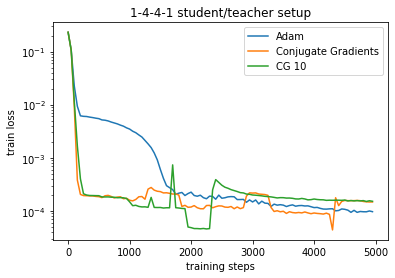

In [33]:
plt.plot(steps, adam_losses, label='Adam')
plt.plot(steps, cg_losses, label="Conjugate Gradients")
plt.plot(steps, cg10_losses, label="CG 10")
plt.yscale('log')
plt.legend()
plt.title("1-4-4-1 student/teacher setup")
plt.ylabel("train loss")
plt.xlabel("training steps")